# Trajectory detection and isolation


## Data

<div style="padding-top: 10px; font-size: 15px;">
We'll start from the previously saved AnnData of metacells that we called `1_CombinedMetaCells.h5ad`
If you didn't manage to save it, you can copy it in your fodlers from the shared one. Open a terminal and copy this command (changing the path to the shared folder):
</div>

```
rsync <PATH/TO/SHARED/FOLDER>/1_CombinedMetaCells.h5ad $HOME/BrainOmics2024/2_Day2
```

## Notebook content
<div font-size: 15px;">
<ul>
<li>Metacells processing</li>
<li>Trajectory inference with Palantir</li>
</ul>

</div>

---

# Library loading

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
import warnings
import yaml
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.external as sce
import scipy.sparse as sp
import statsmodels.api as sm
import scanpy as sc
import numpy as np
import pandas as pd


import matplotlib.pyplot 
import scanpy.external as sce
from matplotlib.colors import TwoSlopeNorm
import warnings
warnings.filterwarnings('ignore')

import plotly.graph_objects as go
from scipy import stats
warnings.filterwarnings('ignore')
import scvelo as scv
import plotly.express as px
import plotly.io as pio
import itertools
import decoupler as dc
import sys
pio.renderers.default = "jupyterlab"
import random
random.seed(1)


In [2]:
homeDir = os.getenv("HOME")

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

import matplotlib.pyplot as plt
sys.path.insert(1, "./utils/")


from CleanAdata import *
from SankeyOBS import *


scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


# 1. Metacells processing
## 1.1 Load metacells data

<div style="padding-top: 10px; font-size: 15px;">
We load the metacells object and log-normalize the counts for downstream analysis:

In [3]:
CombinedAdata = sc.read_h5ad("./1_CombinedMetaCells.h5ad")

sc.pp.normalize_total(CombinedAdata, target_sum=2e4)
sc.pp.log1p(CombinedAdata)
CombinedAdata

normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 3200 × 16324
    obs: 'kmeans_clusters', 'AggregatedClass', 'AggregatedLabel', 'Auth_Sample.ID', 'Auth_Age', 'Auth_Tissue.ID', 'Auth_Sample.Type', 'Auth_Assay', 'Auth_Batch', 'dataset_id', 'sample_id', 'brain_region', 'age', 'stage', 'batch_key', 'Auth_Assay_formatted', 'scDblFinder.class'
    uns: 'log1p'
    layers: 'median'

<div style="padding-top: 10px; font-size: 15px;">
Here we remove "AggregatedLabel" with less than 10 metacells:

In [4]:
# Keep only clusters with at least 10 cells
AggregatedOBS = CombinedAdata.obs["AggregatedLabel"].value_counts().loc[CombinedAdata.obs["AggregatedLabel"].value_counts() > 10].index.tolist()
CombinedAdata = CombinedAdata[CombinedAdata.obs["AggregatedLabel"].isin(AggregatedOBS)]

## 1.2 Re-compute HVGs, neighbors and PCA

<div style="padding-top: 10px; font-size: 15px;">

We process the metacells dataset similarly to what done during Day 1 for the single cell dataset. You can notice that the computation are much faster.

In [5]:
n_neighb = 30
n_pcs = 5

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    with n_comps=50
    finished (0:00:01)


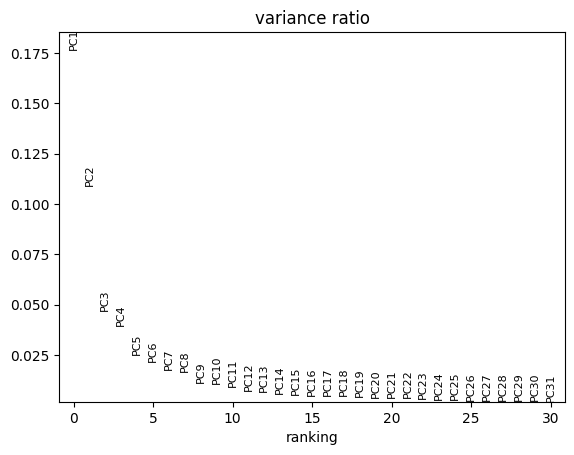

computing neighbors
    using 'X_pca' with n_pcs = 5
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


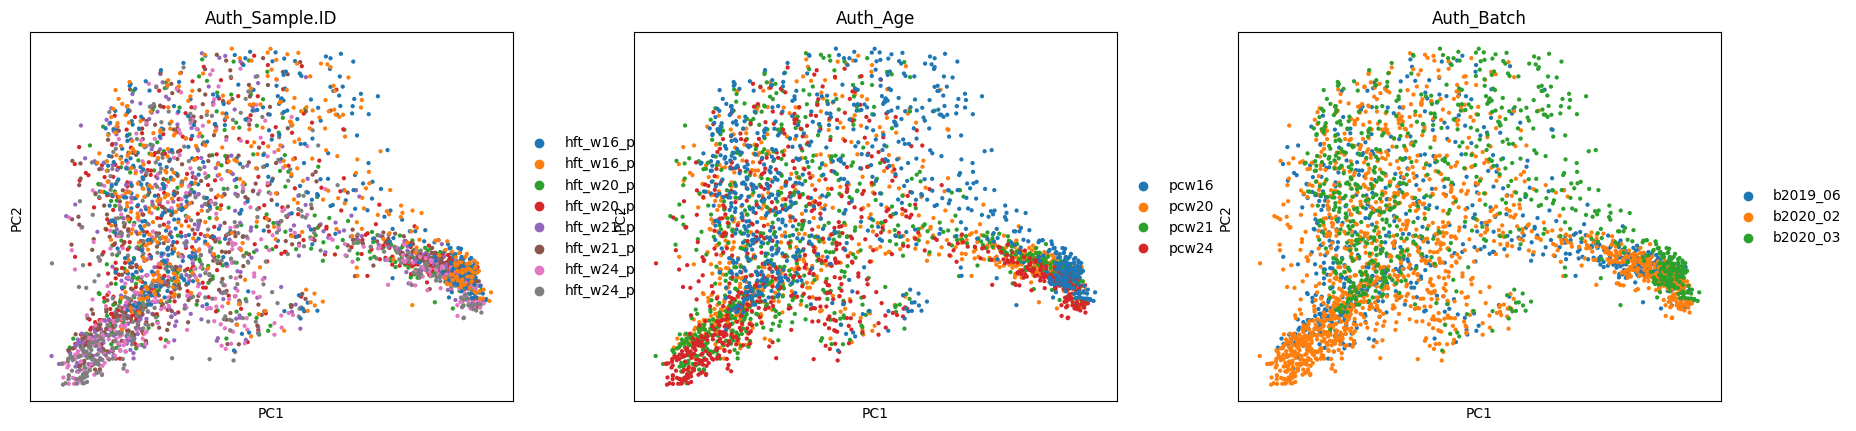

In [6]:
sc.pp.highly_variable_genes(CombinedAdata, n_top_genes=2000, flavor="seurat", batch_key="Auth_Sample.ID")
CombinedAdata.var["highly_variable"] = CombinedAdata.var["highly_variable_nbatches"] >= 2 
sc.tl.pca(CombinedAdata)
sc.pl.pca_variance_ratio(CombinedAdata)
sc.pp.neighbors(CombinedAdata, n_neighbors=n_neighb, n_pcs=n_pcs, metric="euclidean")
sc.tl.umap(CombinedAdata)
ax = sc.pl.pca(CombinedAdata, color=["Auth_Sample.ID","Auth_Age","Auth_Batch"], show=False)


In [7]:
plotSankey(CombinedAdata, covs=["Auth_Sample.ID","Auth_Age","Auth_Batch"])

<div class="alert alert-block alert-warning" style="padding-top: 10px; font-size: 15px;"><b>NOTE on HVGs</b>

**We specify:**

```

sc.pp.highly_variable_genes(CombinedAdata, n_top_genes=2000, flavor="seurat", **batch_key="Auth_Sample.ID"**)

CombinedAdata.var["highly_variable"] = CombinedAdata.var["highly_variable_nbatches"] **>= 2**

```

 Because we want to employ ony highly variable genes deriving from at **least 2 samples**, so to avoid including HVG exclusive for a specific batch.

</div>

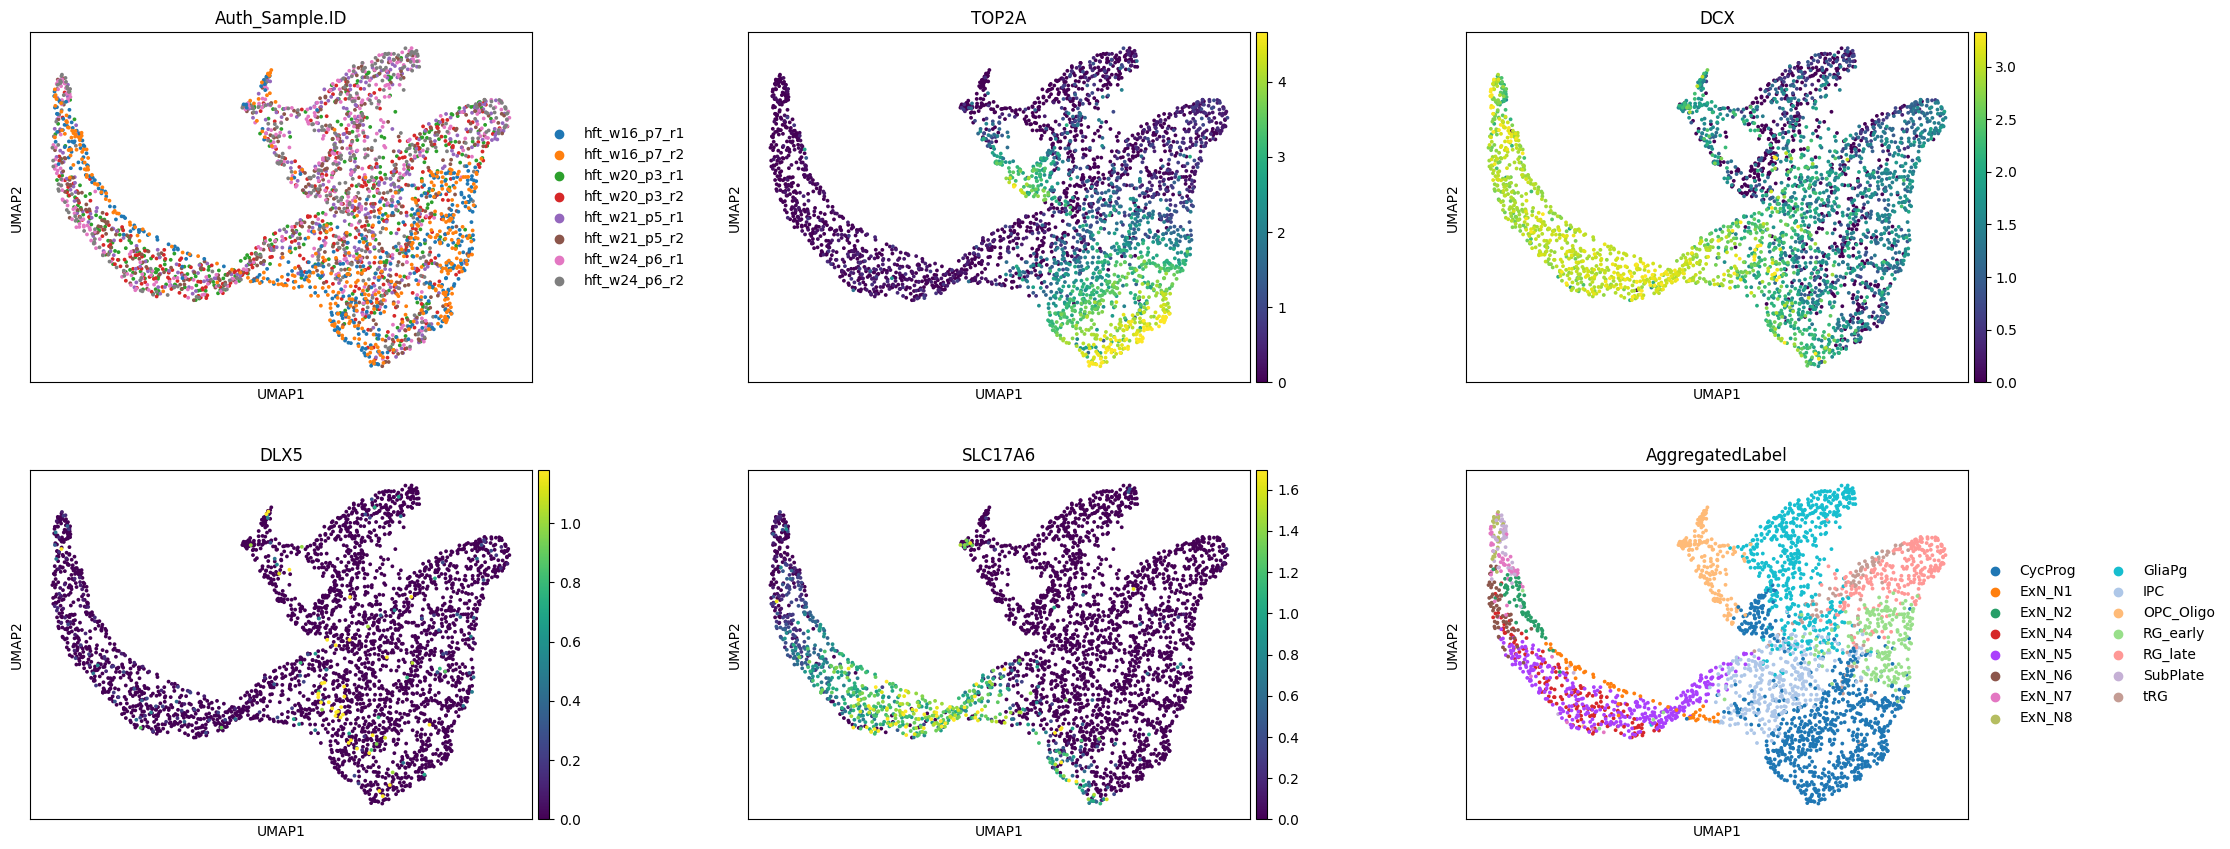

In [8]:

sc.pl.umap(CombinedAdata, color=["Auth_Sample.ID","TOP2A","DCX","DLX5","SLC17A6","AggregatedLabel"], ncols=3, wspace=.3, size = 30, vmin='p1', vmax='p99')

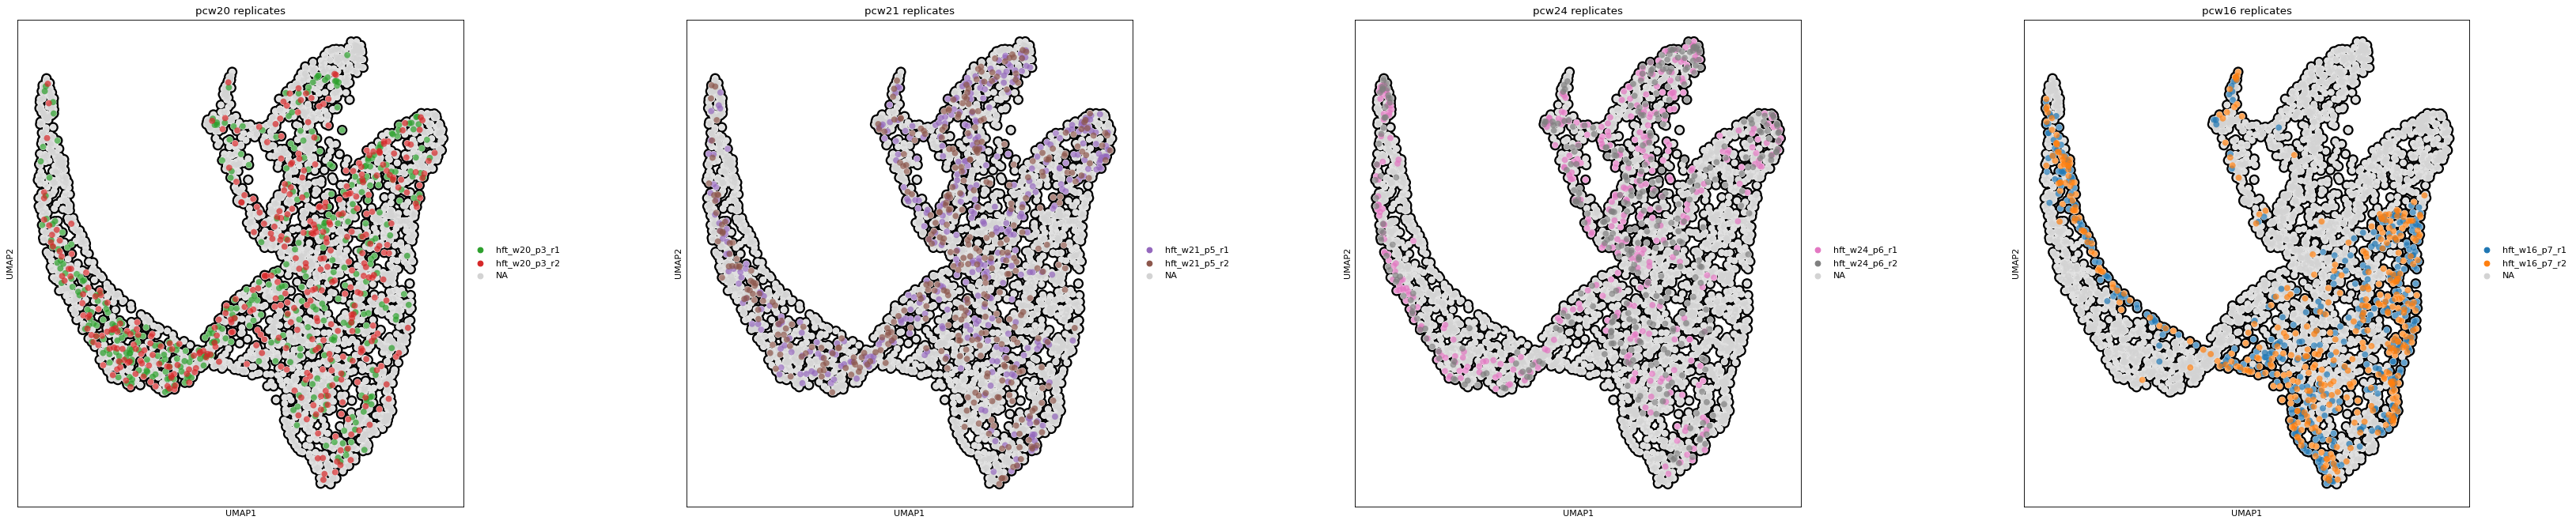

In [9]:
fig, axes = plt.subplots(1,len(CombinedAdata.obs.Auth_Age.unique()), figsize=(50, 10), dpi=80)
for Auth_Age in enumerate(CombinedAdata.obs.Auth_Age.unique()):
    SampleIDs = CombinedAdata.obs.loc[CombinedAdata.obs.Auth_Age == Auth_Age[1],"Auth_Sample.ID"].unique().tolist()
    axes[Auth_Age[0]] = sc.pl.embedding(CombinedAdata, size = 200, add_outline=True,ncols=2, color=["Auth_Sample.ID"],title="{} replicates".format(Auth_Age[1]),
                     groups=SampleIDs, vmin='p1', vmax='p99', show=False, ax=axes[Auth_Age[0]], basis = "umap")

plt.subplots_adjust(wspace=.5)
fig.show()

<span style="color: red" style="padding-top: 10px; font-size: 15px;">
    
**What are your observations about the distribution of markers and distribution of batches?**

## 1.3 Perform a fresh integration on the new metacells anndata

<div class="alert alert-block alert-info" style="padding-top: 10px; font-size: 15px;">

<b>NOTE: Pre-processing</b>

After steps that involve alteration of the relationships among cells consider re-computing **PCA/Neighbors and/or HVGs** , e.g.:

* `Integration`
* `Filtering`
* `Subsetting`

In [10]:
CombinedAdata = CleanAdata(CombinedAdata, obstokeep=CombinedAdata.obs.columns.tolist(), obsmtokeep="X_pca")
sce.pp.harmony_integrate(CombinedAdata, key="Auth_Batch", max_iter_harmony=20, theta =3)

2024-11-12 16:36:22,811 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-12 16:36:24,368 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-12 16:36:24,396 - harmonypy - INFO - Iteration 1 of 20
2024-11-12 16:36:24,831 - harmonypy - INFO - Iteration 2 of 20
2024-11-12 16:36:25,258 - harmonypy - INFO - Iteration 3 of 20
2024-11-12 16:36:25,647 - harmonypy - INFO - Iteration 4 of 20
2024-11-12 16:36:26,076 - harmonypy - INFO - Iteration 5 of 20
2024-11-12 16:36:26,498 - harmonypy - INFO - Iteration 6 of 20
2024-11-12 16:36:26,935 - harmonypy - INFO - Iteration 7 of 20
2024-11-12 16:36:27,150 - harmonypy - INFO - Iteration 8 of 20
2024-11-12 16:36:27,476 - harmonypy - INFO - Iteration 9 of 20
2024-11-12 16:36:27,645 - harmonypy - INFO - Iteration 10 of 20
2024-11-12 16:36:27,835 - harmonypy - INFO - Iteration 11 of 20
2024-11-12 16:36:28,265 - harmonypy - INFO - Iteration 12 of 20
2024-11-12 16:36:28,554 - harmonypy - INFO - Converged after

<div style="padding-top: 10px; font-size: 15px;">

In this case __force-directed graph__ can be an useful visualization tool that better capture relationships among cells (i.e., lineages). It is a different low-dimensional representation of the data which algorithm where similarities and differences between cells are forces that drives the distribution of cells in space, maximizing the distance between cells that are different (which will "repulse" each other) and minimizing the one between similar cells. For reference: [Scanpy's API](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.draw_graph.html)

In [11]:
sc.pp.neighbors(CombinedAdata, n_neighbors=n_neighb, n_pcs=n_pcs, use_rep="X_pca_harmony")
sc.tl.draw_graph(CombinedAdata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:18)


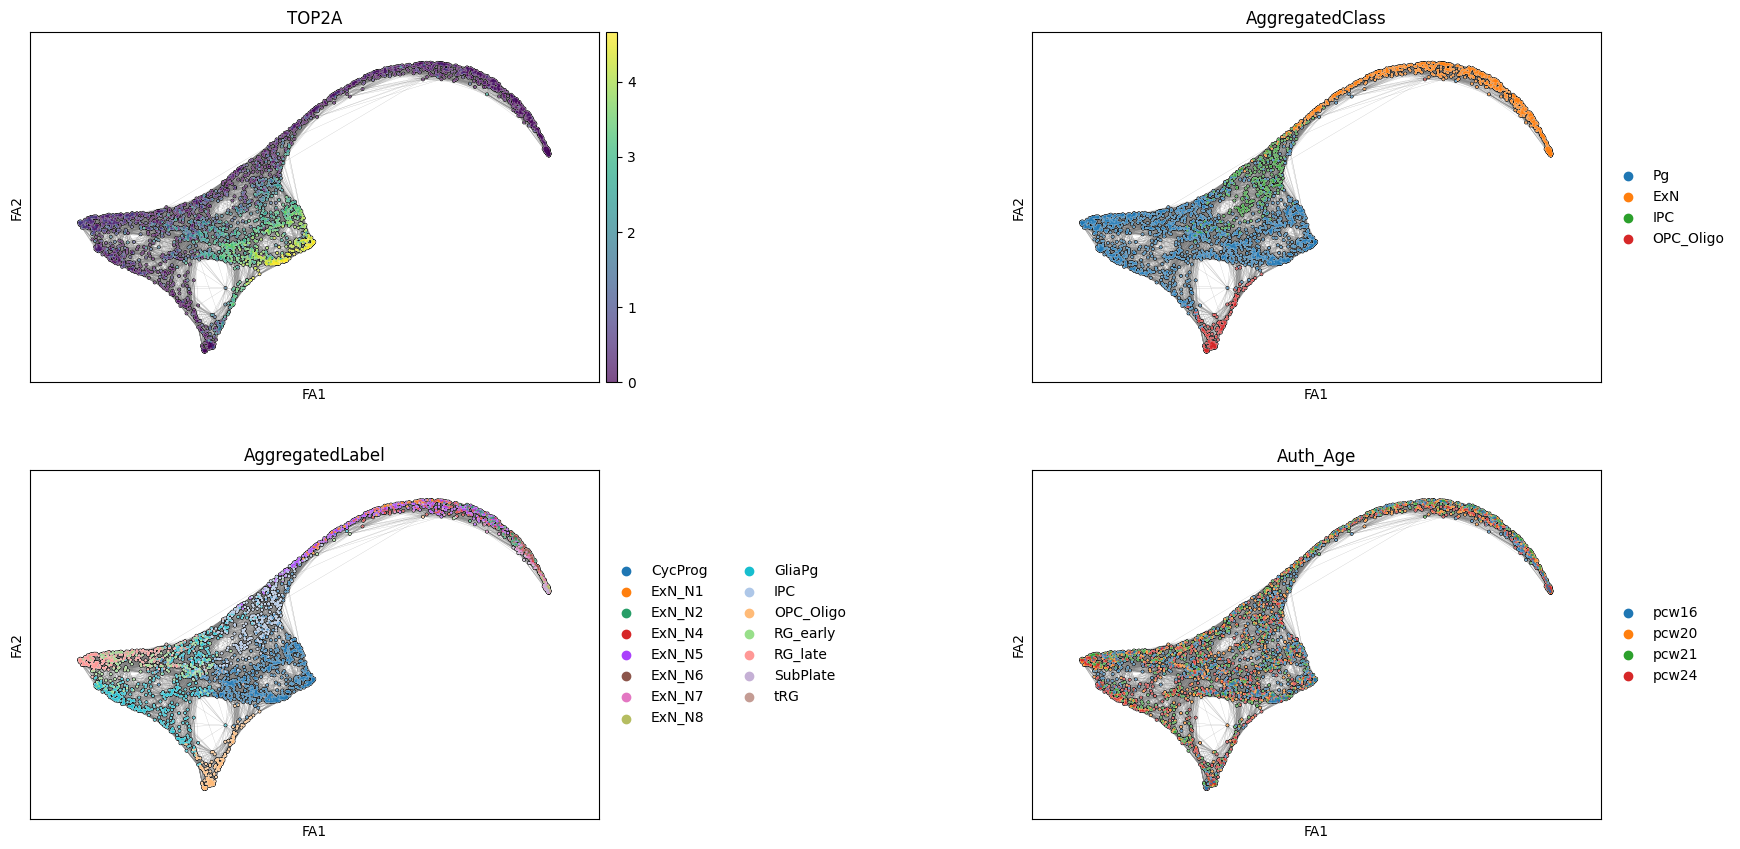

In [12]:

sc.pl.draw_graph(CombinedAdata, color=["TOP2A","AggregatedClass","AggregatedLabel","Auth_Age"], size=10, wspace=.6, ncols=2, vmin='p1', vmax='p99', add_outline=True, edges=True)

<div class="alert alert-block alert-warning" style="padding-top: 10px; font-size: 15px;"><b>NOTE: 2D dimensionality reduction limitations:</b>

UMAP, tSNE and also Force-directed graphs embed cells in 2D space, and should **NEVER be employed to draw conclusions** from their inspection. They should be used as a **visual support**



# 2. Find top markers for each cell state we want to study

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


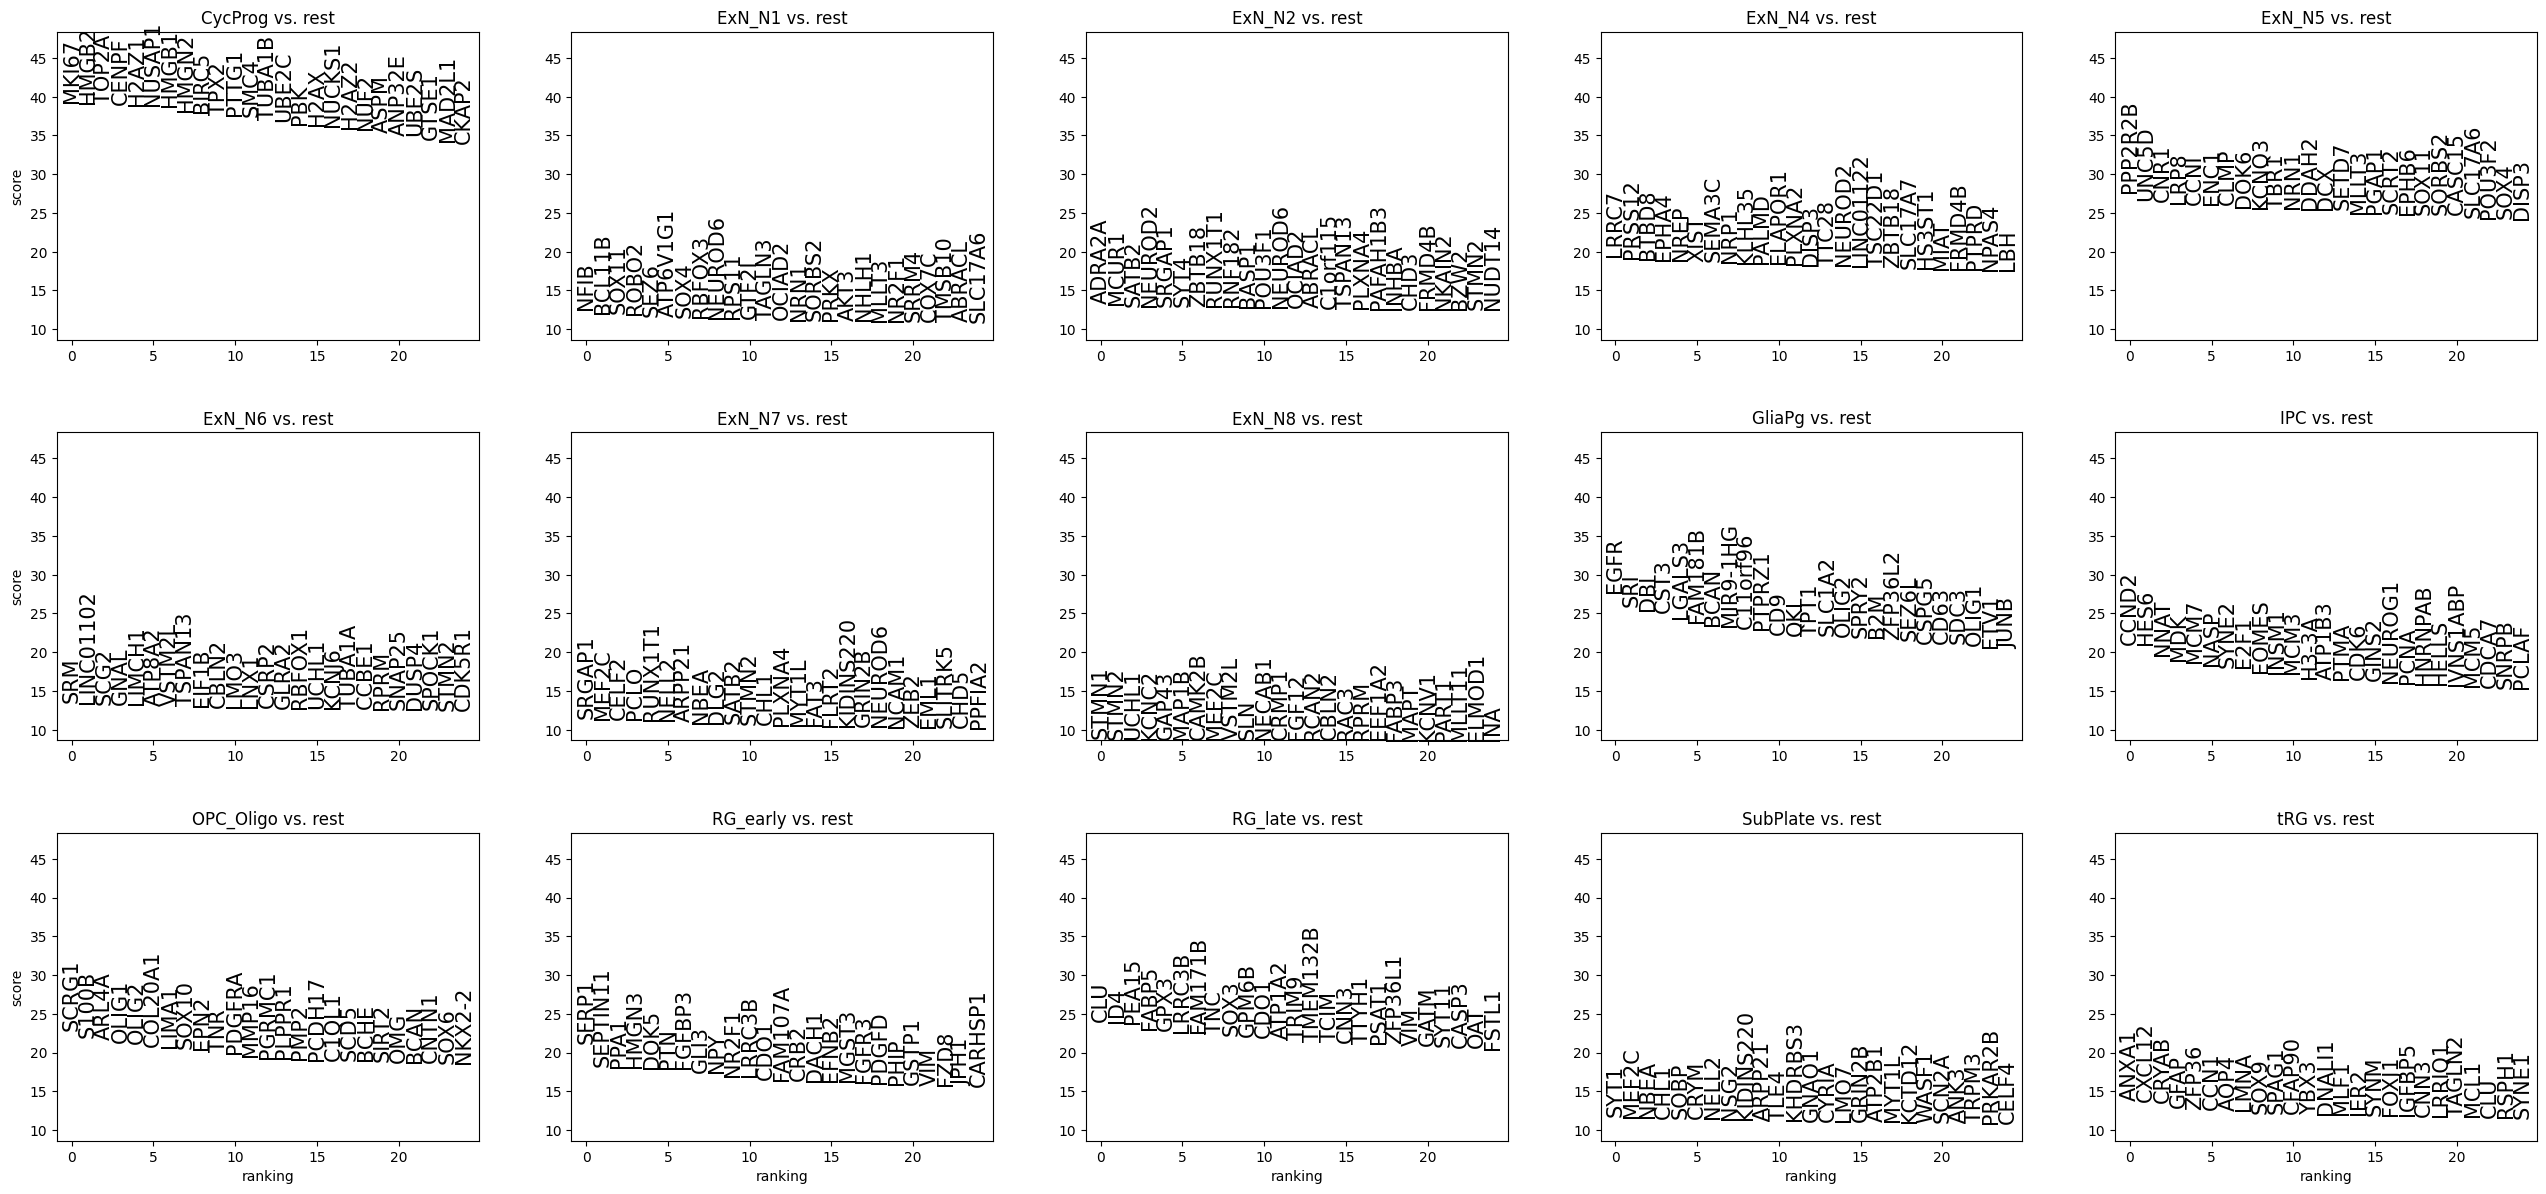

In [13]:
sc.tl.rank_genes_groups(CombinedAdata, groupby="AggregatedLabel", method="wilcoxon", n_genes=1000)
sc.pl.rank_genes_groups(CombinedAdata, n_genes=25, ncols=5, fontsize=15)


# 5. Trajectory inference: Palantir

<div style="padding-top: 10px; font-size: 15px;">
    
There are several tools thanks to which you can infere developmental trajectories in single cell, here we are employing a pseudo-time based method, called [Palantir](https://www.nature.com/articles/s41587-019-0068-4) that "models trajectories of differentiating cells by treating cell fate as a probabilistic process and leverages entropy to measure cell plasticity along the trajectory".
It will generate a pseudo-time ordering of cells and, for each cell state, assigns a probability for differentiating into each terminal state.

## 5.1 Diffusion map

In [14]:
import palantir
dm_res = palantir.utils.run_diffusion_maps(CombinedAdata, knn=50, pca_key="X_pca_harmony", n_components=7)
ms_data = palantir.utils.determine_multiscale_space(CombinedAdata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


## 5.2 Counts imputation: **MAGIC**

<div>
  <img src="https://www.cell.com/cms/10.1016/j.cell.2018.05.061/asset/fb5c94be-02d1-44cb-93b4-86ea62aa1f7d/main.assets/fx1_lrg.jpg" width="800">
</div>

<div>
  <p>
    <strong>Reference:</strong> 
    <a href="https://www.cell.com/cell/fulltext/S0092-8674(18)30724-4">Recovering Gene Interactions from Single-Cell Data Using Data Diffusion</a>
  </p>
</div>

<div style="padding-top: 10px; font-size: 15px;">
   <p style="font-style: italic;">
     MAGIC takes an observed count matrix and recovers an imputed count matrix representing the likely expression for each individual cell based on data diffusion between similar cells.<br>
     For a given cell, MAGIC first identifies the cells that are most similar and aggregates gene expression across these highly similar cells to impute gene expression.<br>
     This approach helps correct for dropout and other sources of noise, leading to a more accurate representation of gene expression at the single-cell level.
   </p>
</div>


<div class="alert alert-block alert-info" style="padding-top: 10px; font-size: 15px;">
  <b>NOTE: Here magic imputed data will be useful to:</b>

  * Better selecting the endpoints of **expected** tajectories




In [15]:
if "MAGIC_imputed_data" not in CombinedAdata.layers.keys():
    imputed_X = palantir.utils.run_magic_imputation(CombinedAdata)

In [16]:
markerList = ["SOBP","CLU","SCRG1", "TOP2A"]

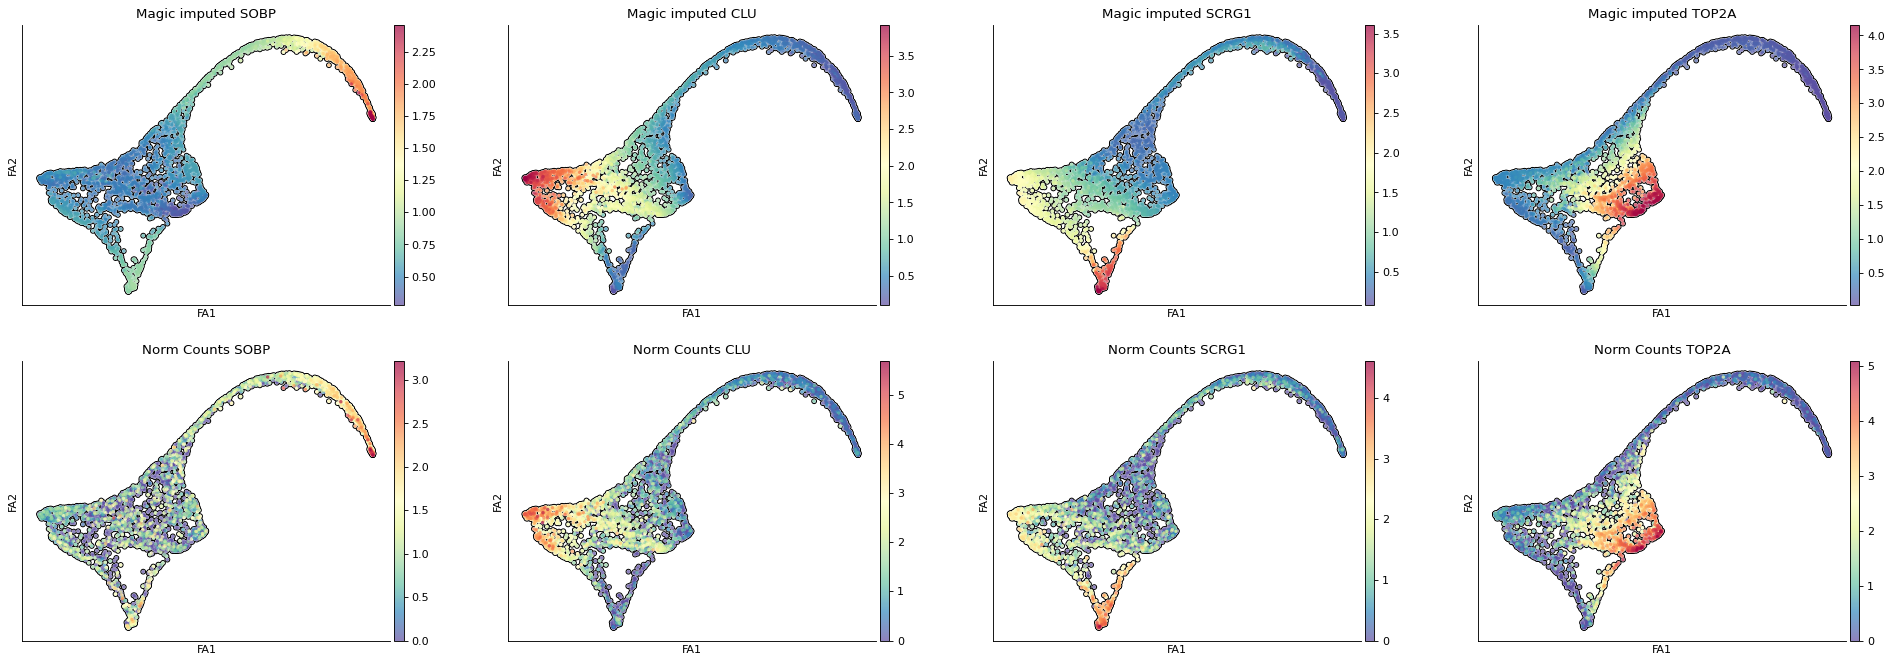

In [17]:
fig, axes = plt.subplots(2, len(markerList), figsize=(30, 10), dpi=80)

for i in ['Magic imputed', 'Norm Counts']:  # Corrected typo here
    if i == 'Magic imputed':  # Changed condition to compare to string
        for n, m in enumerate(markerList):
            axes[0][n] = sc.pl.draw_graph(CombinedAdata, color=m, layer="MAGIC_imputed_data", ax=axes[0][n], show=False, add_outline=True, title=[i+" "+m])
    if i == 'Norm Counts':  # Changed condition to compare to string
        for n, m in enumerate(markerList):
            axes[1][n] = sc.pl.draw_graph(CombinedAdata, color=m, ax=axes[1][n], show=False, add_outline=True, title=[i+" "+m])

plt.show()


## 5.3 Selection of terminal states

<div style="padding-top: 10px; font-size: 15px;">
Each of the markers plotted above represents a marker of a terminal state, that is a more differentiated state (excitatory neurons for SOBP, outer radial glia for CLU and oligodendrocytes for SCRG1) or the marker of the initial states, corresponding to the less differentiated cells (TOP2A). We select as endpoint cell the one expressing the highest value of those markers.

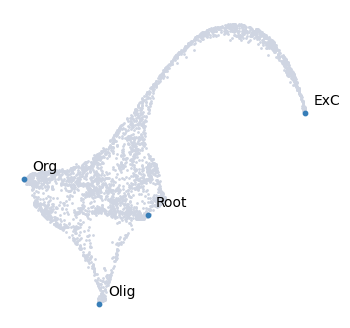

In [18]:
#Cells selection
start_cell = CombinedAdata.obs_names[CombinedAdata[:,"TOP2A"].layers["MAGIC_imputed_data"].argmax()]
terminal_states = pd.Series(
    ["ExC", "Org","Olig"],
    index=[CombinedAdata.obs_names[CombinedAdata[:,"SOBP"].layers["MAGIC_imputed_data"].argmax()], 
           CombinedAdata.obs_names[CombinedAdata[:,"CLU"].layers["MAGIC_imputed_data"].argmax()],
           CombinedAdata.obs_names[CombinedAdata[:,"SCRG1"].layers["MAGIC_imputed_data"].argmax()]],
)
palantir.plot.highlight_cells_on_umap(CombinedAdata, pd.concat([terminal_states, pd.Series(["Root"], index=[start_cell])]), embedding_basis="X_draw_graph_fa")
plt.show()

## 5.3 Actual trajectory inference

<div style="padding-top: 10px; font-size: 15px;">
For each of the endpoints we can isolate the trajectories going from the root to the endpoint cells.

Sampling and flocking waypoints...
Time for determining waypoints: 0.005171076456705729 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.2248205542564392 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


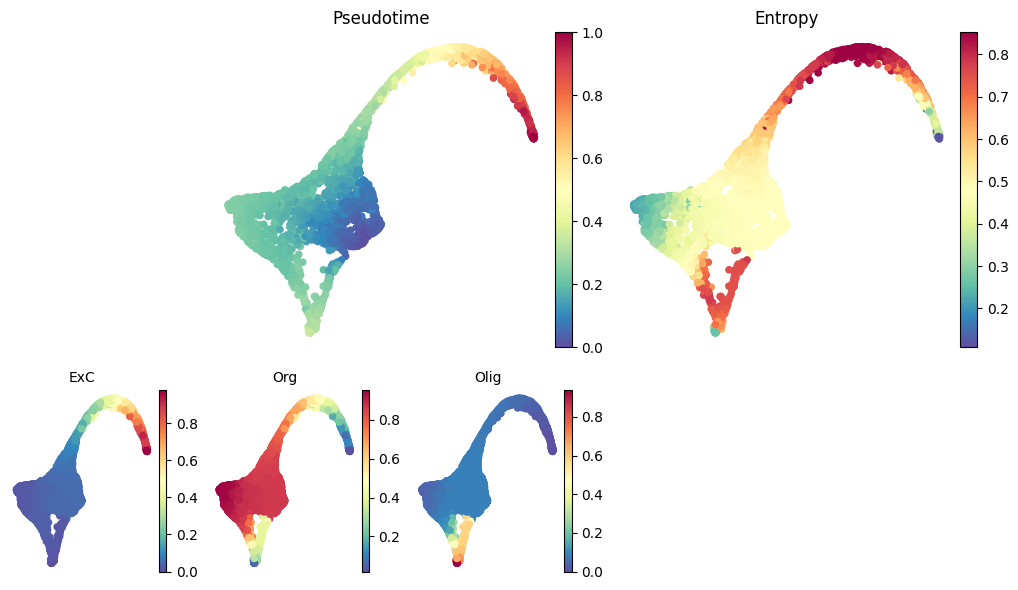

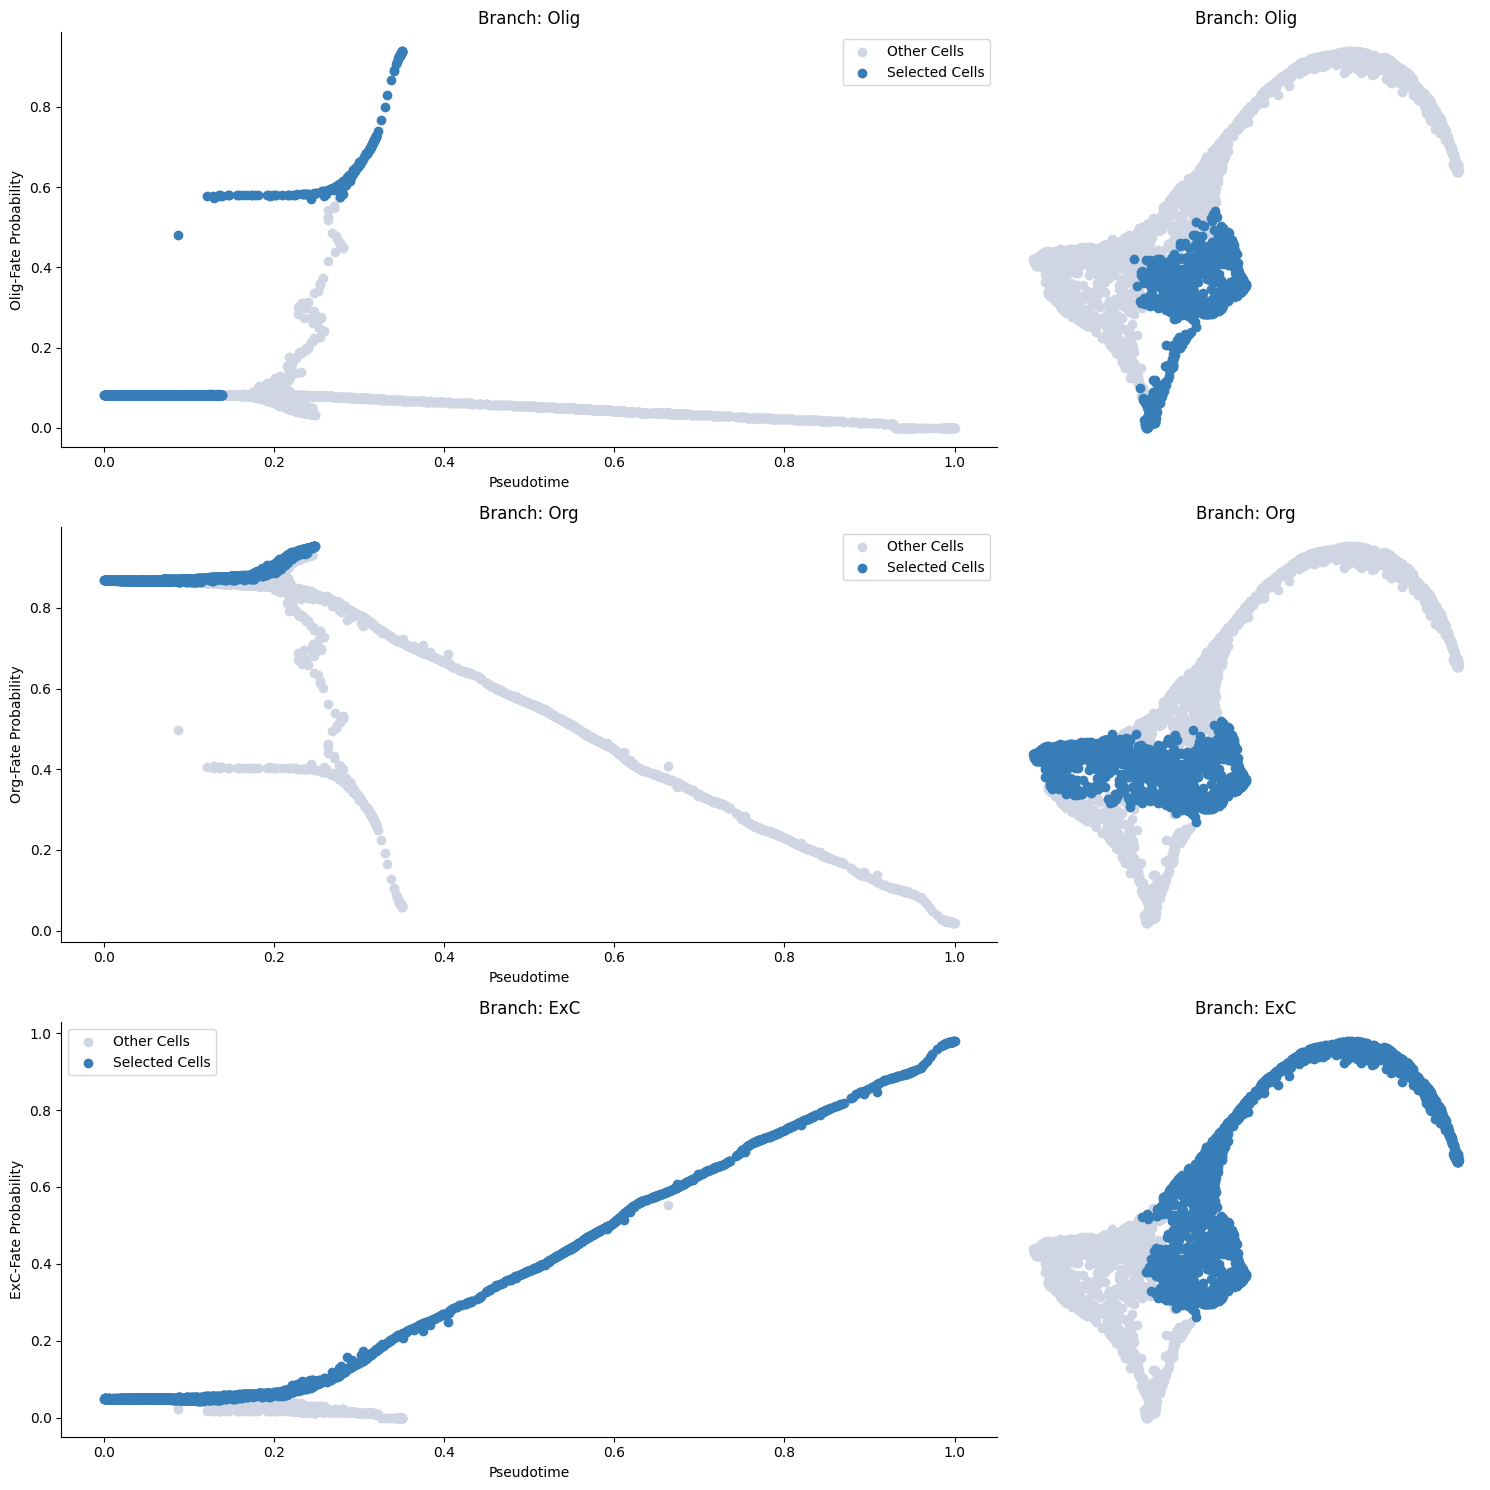

In [19]:
pr_res = palantir.core.run_palantir(CombinedAdata, early_cell=start_cell, terminal_states=terminal_states,knn=30,use_early_cell_as_start=True)
palantir.plot.plot_palantir_results(CombinedAdata, s=20,embedding_basis="X_draw_graph_fa")
plt.show()

palantir.presults.PSEUDOTIME_RES = CombinedAdata.n_obs

masks = palantir.presults.select_branch_cells(CombinedAdata, q=.01, eps=.01)

palantir.plot.plot_branch_selection(CombinedAdata,embedding_basis="X_draw_graph_fa")
plt.show()

# Save anndata with trajectories

In [20]:
CombinedAdata.write("./2_TrajectoriesAdata.h5ad")